# **Lecture Transfer Learning**


Transfer learning is a method in which a model developed for one task is reused as a starting point for a model on a second task.

We know that the starting layers of any neural network model learns features such as patterns, edges etc. These types of features form a crucial part in any classification problem as we would need to identify these basic features for any custom dataset. Thus training a model again just to identify the basic features is not very efficient.

Transfer learning provides us a way to use the initial pre-trained layers of one model as a starting point for another model.

<br>

<img src ="https://drive.google.com/uc?export=view&id=1i2W68dRrvUEFcT--KgKX46PWnVdcyLe5" width=500>

<br>

This saves the vast compute time and resources required to develop neural network models from scratch.

`Torchvision` library of PyTorch provides many models that are pre-trained on ImageNet dataset. ImageNet is a publicly available dataset which consists of 1 million images belonging to 1000 different classes. The custom dataset that we are using in this course is also a subset of the ImageNet dataset.

The model that are a part of the torchvision.model library are already pretrained on the ImageNet dataset.

We can use these models and modify the layers accoring to our requirements.

Let us first import all the necesaary libraries and setup W&B Logging..




## **Ways to use pre-trained models**

There are 3 different ways in which you can use pre-trained models:

- Feature Extraction
- Copy the architecture of some pre-trained network
- Freeze some layers and train the remaining layers
- Train over the pre-trained model


# Setup environment

In [1]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # REPLACE WITH YOUR FOLDER

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning')

    data_folder =  Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq
    !pip install torchinfo

else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

    base_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning')
    data_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Determine the storage location based on the execution environment
# If running on Google Colab, use Google Drive as storage
if 'google.colab' in str(get_ipython()):
    custom_function_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    project_folder = model_folder
    # project_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Class/Class - 6/Imagenette_project')
    kaggle_api_folder = base_folder/'data/.kaggle'

# If running locally, specify a different path
else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    custom_function_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Class/Class - 6/Imagenette_project')
    kaggle_api_folder = base_folder/'data/.kaggle'
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

In [3]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from data_module_imagenette2 import ImagenetteDataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import  plot_losses_acc

In [4]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


### **Feature Extraction**

This method is used when the data that we are trying to train on is very similar to the data that the pre-trained model was originally trained on.

In this method we just change the last fully connected layer to give output according to the number of classes in our dataset.

We freeze the rest of the layers by disabling the back-propagation. In this way we have retained the features of all the previous layers and made them non-trainable. We will just train the last output layer.

Let us see how we can implement this:

In [5]:
# Import torchviso.models
import torchvision.models as models

# Get the pre-trained VGG16 model
model = models.vgg16(weights='DEFAULT')

In [6]:
# Display the model structure
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
def count_parameters(model):
  """
  Function to count the number of trainable parameters in the model
  Input: model
  Output: Number of trainable parameters in the input model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print the number of parameters in the model
print(count_parameters(model))

138357544


Now, we will modify the last layer of the network. By default, if we create a new layer, requires_grad will be set to True.

Now, since we have freezed all the model, the number of trainable parameters will be zero.

In [8]:
# Number of trainable parameters after freezing the layers
print(count_parameters(model))

138357544


In [9]:
# Initial input and output features of the last fully connected layer
model.classifier[6].in_features, model.classifier[6].out_features

(4096, 1000)

In [10]:
import torch.nn as nn
# Change the fully connected layer to have 10 output features
model.classifier[6] = nn.Linear(in_features=4096,out_features=10)

In [11]:
# Freeze all the parameters
for param in model.parameters():
    param.requires_grad = False

In [12]:
# Number of trainable parameters after freezing the layers
print(count_parameters(model))

0


In [13]:
# Freeze all the parameters
for param in model.classifier.parameters():
    param.requires_grad = True

count_parameters(model)

119586826

In [14]:
# Display the model structure
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
model = models.vgg16(weights='DEFAULT')

In [16]:
# Freeze all the parameters
for param in model.parameters():
    param.requires_grad = False

In [17]:
model.classifier[6] = nn.Linear(in_features=4096,out_features=10)

# Final input and out features of the last fully connected layer
model.classifier[6].in_features, model.classifier[6].out_features

(4096, 10)

In [18]:
# Final number of trainable parameters
print(count_parameters(model))

40970


In [19]:
4096*10 + 10

# Number of input features * Number of output features + Bias terms (number of output features)

# This is only for final layer as we are only training the output layer

40970

Now, we can use this model for training on our dataset.

This method is used when the dataset is very small and the data similarity is very high.

### **Copy the architecture**

In this method, we create a model with the same architecture as a pre-trained model which has previously shown good results in performing the task similar to the task that we are trying to perform.

In this method, we don't use the pre-trained weights, just the architecture and re-train the en tire model on our dataset.

This method is used when our dataset is large enough and not very similar to the dataset that our model was initially trained on.

We can do this by declaring the `pretrained` parameter as `False` while using any model from the torchvision library as this will not load the pretrained weights of the model.

In [20]:
# Get the VGG16 model architecture without getting the pretrained weights
model2 = models.vgg16(weights=None)

In [21]:
# Display the model structure
model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
# Print the number of parameters in the model
print(count_parameters(model2))

138357544


We have used this method for training the different models in Lecture 6.

### **Freeze some layers**

In this method, we freeze the some of the first layers of the network and train the rest of the layers. This is done due to fact that the initial layers retain the most basic structural information and this information can be stored and used for any dataset.

For example the filter that has been trained to detect edges on a dataset containing animals can also be used to detect edges for a dataset containing fruits. Thus, we can freeze the initial layers and train the model for the rest of the layers.

This method is used when the dataset is small and the data similarity is also less.



In [23]:
# Get the pre-trained VGG16 model
model3 = models.vgg16(weights='DEFAULT')

In [24]:
# Display the model structure
model3

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Let's freeze the first 12 convolution layers of the model. To do this, we have to first look at the structure of the model.

We can see that the we have to freeze the layers 0-27 of features.

In [25]:
# Print the number of parameters in the model
print(count_parameters(model3))

138357544


In [26]:
c = 0
for param in model3.parameters():
    c+=1
    param.requires_grad = False
    if c>27:
        break

In [27]:
# Print the number of parameters in the model
print(count_parameters(model3))

20878312


### **Train over the pre-trained model**

There is another method in which we retain the whole architecture as well as the pre-trained weights of the model and use them as the initial weight initialization for the training the model on the new dataset.

This is done when data similarity is high as well as the size of the dataset is also very large.




# Case Study - Transfer Learning imagenette2 dataset

- USE VGG - free all the faetures (Convoilutional Layers)
- Unfreeze Classification Layer
- Change the last Linerar layer based on you model output

In [28]:
train_transform = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Resize((227, 227)),
                                       transforms.RandomRotation(5),
                                       transforms.RandomHorizontalFlip(0.5),
                                       transforms.RandomCrop((227, 227)),
                                       transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                            std = [0.229, 0.224, 0.225])
                                      ])

valid_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((227, 227)),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                            std = [0.229, 0.224, 0.225])
                                                     ])

# Function to load the model

In [29]:
# Function to load the model
def load_model():
    model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
    model.classifier[0].requires_grad_(True)
    model.classifier[3].requires_grad_(True)
    model.classifier[6].requires_grad_(True)

    return model

In [30]:
count_parameters(load_model())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


119586826

In [31]:
(25088*4096+4096) + (4096*4096+4096) + (4096*10+10)

119586826

# Functions for Transformations

In [32]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )


# Function to load DataModule

In [33]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = ImagenetteDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

# Function to load LightningModule

In [34]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


# Function to load the Trainer

In [35]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [36]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model()

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [37]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [38]:
project_folder = custom_function_folder

In [39]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config


# Function to free memory

In [40]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [41]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccura

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.12, Val_Metric: 0.38 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.35, Train_Metric: 0.05


# Find Learning Rate

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.31, Val_Metric: 0.08 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Val_Loss: 55.36, Val_Metric: 0.13 | 

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 18 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0006812920690579612
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_3811d670-a80d-418f-b962-f1bf498569c1.ckpt


Train_Loss: 5.77, Train_Metric: 0.51


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_3811d670-a80d-418f-b962-f1bf498569c1.ckpt


0.0006812920690579612


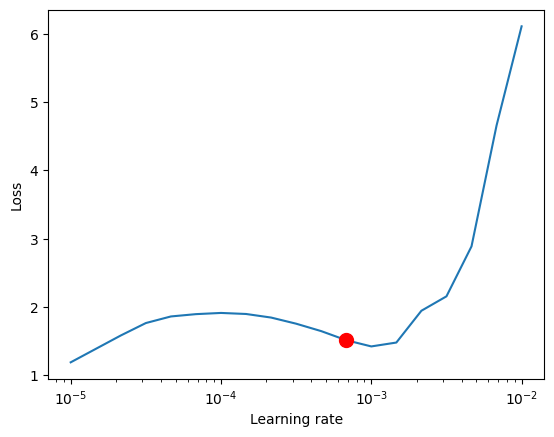

In [42]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


# Overfit Small Subset

In [43]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=64
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.0007
trainer_config['max_epochs']=3
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 |

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.32, Val_Metric: 0.11 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:262: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 5.90, Val_Metric: 0.11 | Train_Loss: 2.39, Train_Metric: 0.06


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 25.09, Val_Metric: 0.11 | Train_Loss: 0.00, Train_Metric: 1.00


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 56.72, Val_Metric: 0.11 | Train_Loss: 0.00, Train_Metric: 1.00


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


# Regularization -I
- 5 Epochs
- Gradient Clipping
- Complete Dataset

INFO:lightning_fabric.utilities.seed:Global seed set to 42
wandb: Currently logged in as: harikrish0607 (harikrishnad). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs e

Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.31, Val_Metric: 0.10 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 0.07, Val_Metric: 0.98 | Train_Loss: 0.23, Train_Metric: 0.94


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 0.09, Val_Metric: 0.97 | Train_Loss: 0.05, Train_Metric: 0.98


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.08, Val_Metric: 0.98 | Train_Loss: 0.02, Train_Metric: 0.99


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.10, Val_Metric: 0.98 | Train_Loss: 0.01, Train_Metric: 1.00


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.10, Val_Metric: 0.98 | Train_Loss: 0.01, Train_Metric: 1.00


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


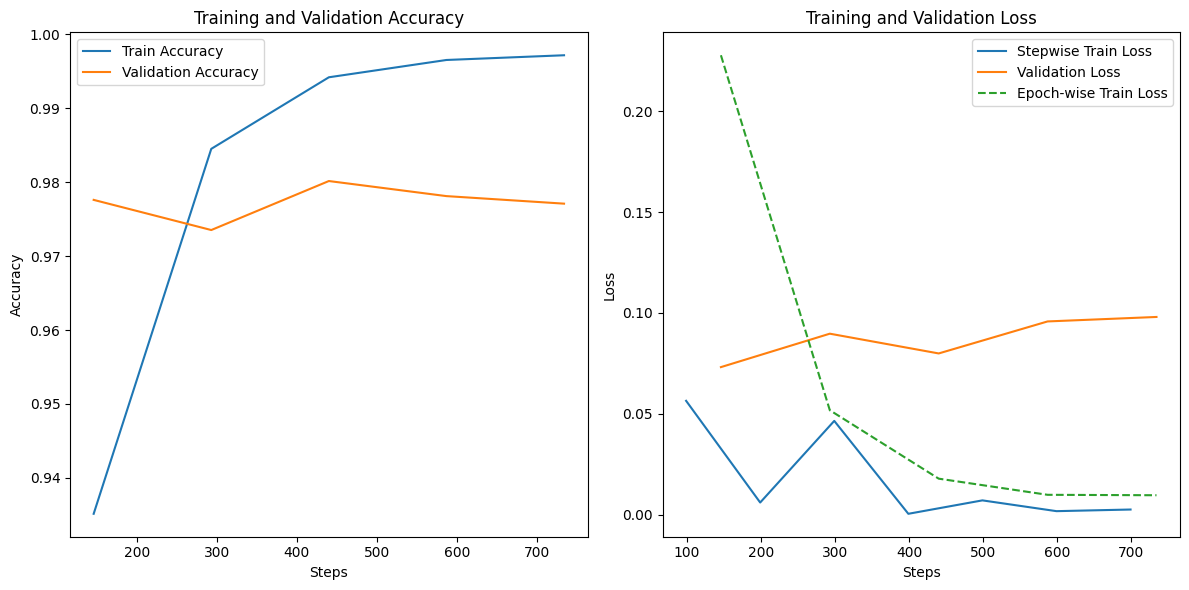

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/epoch=2-step=441-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/epoch=2-step=441-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.00, Val_Metric: 1.00 | 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/epoch=2-step=441-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/epoch=2-step=441-v1.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.08, Val_Metric: 0.98 | Train Accuracy: 99.91
Validation Accuracy: 98.01


epoch,▁▁▁▂▂▂▄▄▄▄▅▅▅▇▇▇▇██
lr-AdamW,▁▁▁▁▁
train_loss_epoch,█▂▁▁▁
train_loss_step,█▂▇▁▂▁▁
train_metric,▁▇███
trainer/global_step,▁▂▂▂▂▃▄▄▄▄▅▅▅▅▆▇▇▇▇█████
val_loss,▆▇▇██▁▇
val_metric,▂▁▃▂▂█▃
epoch,5
lr-AdamW,0.0001
train_loss_epoch,0.0097


In [44]:
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=5
trainer_config['gradient_clip_val']=1
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.0
lightning_module_config['others']['learning_rate']=0.0001
# lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
# lightning_module_config['scheduler_params']= {'mode': 'min', 'patience': 0, 'factor': 0.5, 'verbose': True}
# lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_CNN'
cl_config['wandb']['name']='simple_cnn_exp1'

# Data Module
data_module_config['data_module']['batch_size']=64
data_module_config['data_module']['small_subset']=False
data_module_config['data_module']['num_samples_small']=1.0

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()